# Trabajo Práctico NLP: Detección de Tópicos y Clasificación

**Mariela Iaccarino**

Certificación Experta en NLP - ITBA

In [78]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [79]:
!pip install --upgrade umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Requirement already up-to-date: umap-learn in /home/RECONQUISTA/a118672/.local/lib/python3.8/site-packages (0.5.6)


In [80]:
!pip install chromadb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [81]:
!pip install hdbscan

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [82]:
!pip install sentence_transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [83]:
!pip install BERTopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [84]:
!pip install opensearch-py==2.3.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [86]:
from bertopic import BERTopic
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from opensearch_data_model import Topic, TopicKeyword, os_client
from datetime import datetime
from dateutil.parser import parse
from utils import SPANISH_STOPWORDS

## 1. Configuración y Carga de Datos
Importación de librerías necesarias:

In [87]:
from datasets import load_dataset
import pandas as pd
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from datetime import datetime
from transformers import pipeline
#import chromadb

In [88]:
Topic.init()

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



RequestError: RequestError(400, 'illegal_argument_exception', "Can't update non dynamic settings [[index.knn, index.number_of_shards]] for open indices [[topic/2yYmHkK0TRCgLTswzN0AOg]]")

Carga y preparación de datos:

Se carga un conjunto de datos de noticias de 5 días y se le agrega un campo de fecha.

In [ ]:
import pandas as pd
from datasets import load_dataset

# Función para agregar un campo fecha a un dataset
def add_fecha_field(dataset, fecha):
    df = pd.DataFrame(dataset['train'])
    df['date'] = fecha
    return df

# Cargar un dataset (ejemplo)
ds_1 = load_dataset("jganzabalseenka/news_2024-07-01_24hs")
# Agregar el campo fecha con el valor '2024-07-01'
fecha_deseada = '2024-07-01'
df_1 = add_fecha_field(ds_1, fecha_deseada)

ds_2 = load_dataset("jganzabalseenka/news_2024-07-12_24hs")
fecha_deseada = '2024-07-12'
df_2 = add_fecha_field(ds_2, fecha_deseada)

ds_3 = load_dataset("jganzabalseenka/news_2024-07-14_24hs")
fecha_deseada = '2024-07-14'
df_3 = add_fecha_field(ds_3, fecha_deseada)

ds_4 = load_dataset("jganzabalseenka/news_2024-07-16_24hs")
fecha_deseada = '2024-07-16'
df_4 = add_fecha_field(ds_4, fecha_deseada)


ds_5 = load_dataset("jganzabalseenka/news_2024-07-19_24hs")
fecha_deseada = '2024-07-19'
df_5 = add_fecha_field(ds_5, fecha_deseada)


# Unificar los datasets en un solo DataFrame
df_list = [df_1, df_2, df_3, df_4, df_5]
df = pd.concat(df_list, ignore_index=True)

# Verificar los cambios
print(df.loc[6:16, ['title', 'date']])


Generating train split: 100%|██████████| 17562/17562 [00:00<00:00, 19926.97 examples/s]


                                                title        date
6   Adiós a Ismail Kadare, una luz brillante en lo...  2024-07-01
7   Cristina Kirchner: "El único que sigue creyend...  2024-07-01
8            Receta de pan de centeno, rápida y fácil  2024-07-01
9   Los nuevos eurodiputados españoles acatan hoy ...  2024-07-01
10  Portugal y Eslovenia no se sacan ventajas en l...  2024-07-01
11  Las series más esperadas que llegan a Netflix,...  2024-07-01
12  El Gobierno crea la nueva especialidad de Urge...  2024-07-01
13  Delgado, Orsi y Ojeda serían los candidatos a ...  2024-07-01
14  Nicola Peltz-Beckham ha evaluado demandar a un...  2024-07-01
15  La desoladora reflexión de Pedro Gallese tras ...  2024-07-01
16  Cuándo es firme una sentencia de divorcio cont...  2024-07-01


In [ ]:
# Ver los distintos días en formato fecha
unique_dates = df['date'].unique()
print("Fechas únicas en los conjuntos de datos:")
for date in unique_dates:
    print(date)

Fechas únicas en los conjuntos de datos:
2024-07-01
2024-07-12
2024-07-14
2024-07-16
2024-07-19


In [ ]:
# Dividir el dataset por días
daily_data = {date: data for date, data in df.groupby(df['date'])}

In [ ]:
df.head()

asset_id                                           title_ch  \
0  113231459           Domingo, 30 de junio de 2024 (24:00 GMT)   
1  113327885  Encontraron un golpe, dos pelos y manchas roja...   
2  113332680  Las cinco enfermedades por las que se ha conce...   
3  113222271  Así fue el espectacular cumpleaños de Vida, la...   
4  113233912  Clima en Madrid: conoce el pronóstico y prepár...   

                                   Asset Destination    media  impact  \
0  http://infobae.com/america/agencias/2024/07/01...  Infobae   27969   
1  http://infobae.com/sociedad/policiales/2024/07...  Infobae  181455   
2  http://infobae.com/espana/2024/07/01/las-enfer...  Infobae    9976   
3  http://infobae.com/teleshow/2024/06/30/asi-fue...  Infobae    4465   
4  http://infobae.com/espana/2024/07/01/clima-en-...  Infobae   36487   

       start_time_utc    start_time_local  \
0 2024-07-01 02:36:06 2024-06-30 23:36:06   
1 2024-07-01 20:49:30 2024-07-01 17:49:30   
2 2024-07-01 21:41:47 2024-07-01 18:41:47   
3 2024-07-01 00:25:38 2024-06-30 21:25:38   
4 2024-07-01 03:25:55 2024-07-01 00:25:55   

                                    entities_curated  \
0       [Joe Biden, Consejo Nacional Electoral, CNE]   
1                            [Carlos Pérez, Infobae]   
2                                                 []   
3  [Luisana Lopilato, Georgina Barbarossa, Daniel...   
4                                                 []   

                                            entities  \
0  [Sergio Hernández, Marine Le Pen, Natalia Kidd...   
1  [Mariano de Guzmán, Güemes, Alejandra Mangano,...   
2  [Ana, TSJA, INSS, Social, TSXG, Clínica Univer...   
3  [Noah, Daniela Lopilato, Luisana, Cielo, Luisa...   
4  [Agencia Estatal de Meteorología, Infobae, Aem...   

       predicted_at_entities  ...  \
0 2024-07-01 02:39:47.184910  ...   
1 2024-07-01 20:49:45.393438  ...   
2 2024-07-01 21:43:05.015868  ...   
3 2024-07-01 00:46:17.563947  ...   
4 2024-07-01 03:27:06.116765  ...   

                               entities_transformers  \
0  [Newsroom Infobae Nuevo, FRANCIA, París, Marin...   
1  [Loan, Federico Fahsbender Nuevo, Laudelina Pe...   
2  [Diego Mariño Nuevo, España, Tribunal Superior...   
3  [Vida, Luisana Lopilato, Michael Bublé, Noah, ...   
4  [Madrid, Infobae Noticias, Infobae, Agencia Es...   

                                               title  \
0           Domingo, 30 de junio de 2024 (24:00 GMT)   
1  Encontraron un golpe, dos pelos y manchas roja...   
2  Las cinco enfermedades por las que se ha conce...   
3  Así fue el espectacular cumpleaños de Vida, la...   
4  Clima en Madrid: conoce el pronóstico y prepár...   

                                                text  \
0  30 Jun, 2024 Por  Newsroom Infobae Nuevo FRANC...   
1  1 Jul, 2024 Por  Federico Fahsbender Nuevo En ...   
2  1 Jul, 2024 Por  Diego Mariño Nuevo La pensión...   
3  30 Jun, 2024 Nuevo La creatividad fluye por la...   
4  1 Jul, 2024 Por  Infobae Noticias Nuevo Los pr...   

                                            keywords  \
0  [foto, elecciones presidenciales, cumbre mundi...   
1  [manchas rojas, camioneta, peña, pericia, rast...   
2  [incapacidad permanente, pensión vitalicia, do...   
3  [cumpleaños número, sirenas, hermosa decoració...   
4  [clima templado, grados centígrados, inviernos...   

       predicted_at_keywords  \
0 2024-07-01 02:47:13.676140   
1 2024-07-01 20:55:24.886450   
2 2024-07-01 21:44:05.387330   
3 2024-07-01 01:03:19.114070   
4 2024-07-01 03:27:35.254670   

                                      truncated_text  \
0  30 Jun, 2024 Por  Newsroom Infobae Nuevo FRANC...   
1  1 Jul, 2024 Por  Federico Fahsbender Nuevo En ...   
2  1 Jul, 2024 Por  Diego Mariño Nuevo La pensión...   
3  30 Jun, 2024 Nuevo La creatividad fluye por la...   
4  1 Jul, 2024 Por  Infobae Noticias Nuevo Los pr...   

                                      title_and_text  \
0  Domingo, 30 de junio de 2024 (24:00 GMT)\n30 J...   
1  E

In [ ]:
# Configurar pandas para mostrar todo el contenido de las celdas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Reviso un registro de la base de datos
registro = df.iloc[[1]]


In [ ]:
print(registro)

    asset_id  \
1  113327885   

                                                                                                               title_ch  \
1  Encontraron un golpe, dos pelos y manchas rojas en la camioneta del principal sospechoso por la desaparición de Loan   

                                                                                                                                                                  Asset Destination  \
1  http://infobae.com/sociedad/policiales/2024/07/01/prueba-clave-en-el-caso-loan-analizan-los-resultados-de-la-pericia-a-la-camioneta-del-principal-acusado-de-la-muerte-del-chico   

     media  impact      start_time_utc    start_time_local  \
1  Infobae  181455 2024-07-01 20:49:30 2024-07-01 17:49:30   

          entities_curated  \
1  [Carlos Pérez, Infobae]   

                                                                                                                                                                       

Stopwords en español

In [ ]:
SPANISH_STOPWORDS

['a',
 'actualmente',
 'adelante',
 'además',
 'afirmó',
 'agregó',
 'ahora',
 'ahí',
 'al',
 'algo',
 'alguna',
 'algunas',
 'alguno',
 'algunos',
 'algún',
 'alrededor',
 'ambos',
 'ampleamos',
 'ante',
 'anterior',
 'antes',
 'apenas',
 'aproximadamente',
 'aquel',
 'aquellas',
 'aquellos',
 'aqui',
 'aquí',
 'arriba',
 'aseguró',
 'así',
 'atras',
 'aunque',
 'ayer',
 'añadió',
 'aún',
 'bajo',
 'bastante',
 'bien',
 'buen',
 'buena',
 'buenas',
 'bueno',
 'buenos',
 'cada',
 'casi',
 'cerca',
 'cierta',
 'ciertas',
 'cierto',
 'ciertos',
 'cinco',
 'comentó',
 'como',
 'con',
 'conocer',
 'conseguimos',
 'conseguir',
 'considera',
 'consideró',
 'consigo',
 'consigue',
 'consiguen',
 'consigues',
 'contra',
 'cosas',
 'creo',
 'cual',
 'cuales',
 'cualquier',
 'cuando',
 'cuanto',
 'cuatro',
 'cuenta',
 'cómo',
 'da',
 'dado',
 'dan',
 'dar',
 'de',
 'debe',
 'deben',
 'debido',
 'decir',
 'dejó',
 'del',
 'demás',
 'dentro',
 'desde',
 'después',
 'dice',
 'dicen',
 'dicho',
 'di

Configuración del Modelo de Embeddings y Otros Modelos:

In [ ]:
# Configuración del modelo de embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Configuración de UMAP para reducción de dimensionalidad
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Configuración de HDBSCAN para clustering
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)



## 2. Procesamiento y Detección de Tópicos Diarios

**Análisis de los Tópicos Generados (Ejemplo con la base ds_1 del 2024-07-01):**

Para analizar los tópicos generados en el dataset del 2024-07-01, se podría utilizar el siguiente bloque de código:

In [ ]:
# Obtener los textos del dataset específico
texts = df[df['date'] == '2024-07-01']['text'].tolist()

# Definir el vectorizador usando todas las entidades y keywords únicas del dataset
entities = set(sum(list([list(e) for e in df_1['entities_transformers'].values]), []))
keywords = set(sum(list([list(e) for e in df_1['keywords'].values]), []))
all_tokens = list(entities.union(keywords))

# Configurar el vectorizador
tf_vectorizer = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=SPANISH_STOPWORDS,
    lowercase=False,
    vocabulary=all_tokens,
)

topic_model_1 = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=tf_vectorizer,
    ctfidf_model=ClassTfidfTransformer(),
    representation_model=KeyBERTInspired(),
    language='spanish'
)
topics_1, probs_1 = topic_model_1.fit_transform(texts)

# Mostrar los tópicos generados
for topic in set(topics_1):
    topic_keywords = topic_model_1.get_topic(topic)
    print(f"Tópico {topic}: {', '.join([word[0] for word in topic_keywords])}")


/home/RECONQUISTA/a118672/.local/lib/python3.8/site-packages/bertopic/vectorizers/_ctfidf.py:82: RuntimeWarning:

divide by zero encountered in divide



Tópico 0: Selección Argentina, Primera, Boca, Ecuador, Venezuela, diferencia, Argentina, México, Chile, El
Tópico 1: persecución, pertenencias, disposición, detención, Comando Patrullas, Unidad, investigación, localidad, seguridad, intervención
Tópico 2: canción, canciones, vacaciones, presentación, Buenos, artistas, Córdoba, músico, actividades, reggae
Tópico 3: estación, persecución, conducido, localidad, Científica, vehículo, acceso, tránsito, Renault Sandero, vehículos
Tópico 4: Juan Domingo Perón, historia argentina, Domingo Perón, Juan Domingo, Pero, Nación, Vicente, argentino, San Vicente, Buenos
Tópico 5: Marine Le Pen, elecciones, votación, Los Republicanos, Nacional, Agrupación Nacional, Asamblea Nacional, Le Pen, elecciones legislativas, Nuevo Frente Popular
Tópico 6: combinación, votación, Gran Hermano, eliminación, definición, premio, Bautista Mascia, finalistas, finalista, cariño
Tópico 7: sistema educativo, Educación, educación, Educativa, Ciencias Económicas, Fondo Educ

In [ ]:
df_1['topic'] = topics_1
df_1['probs'] = probs_1

In [ ]:
df_1[df_1['topic']==1][['title_ch', 'topic', 'probs']]

title_ch  \
63                                       26 años del nacimiento de Diana de Gales: una vida marcada por la búsqueda del amor verdadero y un legado social   
202                                                             Consulado de Uruguay en Brasilia sigue la situación de los heridos en vuelo de Air Europa   
519                              Las mujeres tienen menos probabilidades de que se les solucione una ``afección secundaria`` durante una cirugía cardíaca   
616            Una mujer consigue la incapacidad absoluta por sufrir el síndrome de `burnout`: tenía ansiedad y reacciones agudas al estrés en su trabajo   
675                                                                                             Mató de un disparo a un joven que entró a robar a su casa   
715    El relato salvaje de San Justo continuó en el Cullen: el conductor de la camioneta rompió una ventana y le puso el vidrio en el cuello a una mujer   
721                                                                                   Las obras en el hospital de Metán se encuentran avanzadas en un 80%   
761                                                   Llamativo robo: atacaron una casa de fin de semana y solamente se llevaron las cámaras de seguridad   
829                                                                          Realizaron reconocimiento a trabajadores protagonistas de rescates a varados   
849                                                                                                                                      Edição Da Semana   
881                                                                      Villa Mercedes: encuentran el cuerpo de un hombre que habría muerto hace 2 meses   
886                                                                             Dos policías salvaron a un ladrón de ser linchado por un grupo de vecinos   
903                                                                  Siete consejos para ser CEO antes de los 30 años (y cambiar el rumbo de una empresa)   
910                                                                                                                                             Seguridad   
969                                                                             Horror en Monte Grande: Una mujer asesinó a su padre e intentó suicidarse   
1036                                                                          Así fue el impactante incendio de un auto que asustó a los vecinos de Budge   
1049                                                                                                                                           Policiales   
1113                                                  ``Gente que salva vidas``: el estremecedor testimonio de un médico sobre los despidos en el Posadas   
1180                                                               Salud invirtió más de 370 millones de pesos en equipamiento para diferentes hospitales   
1193                                                                                                   Sigue el robo de cables en San Martín de los Ándes   
1206                                                    Encuentran muerto en barrio Villa El Libertador a un hombre de 39 años con un disparo en el pecho   
1227                                                                    Detuvieron a tres personas tras un enfrentamiento en el barrio Macarone de Paraná   
1251                                                                                         CRIMEN DE TATIANA: UNO DE LOS DETENIDOS YA TIENE UNA CONDENA   
1258                                                           Delincuentes sorprendieron mientras dormían a un matrimonio mayor en el acceso a la ciudad   
1266                                                                                                                                            Secciones   
1349                                                           

In [ ]:
len(topics_1), len(df_1)

(16025, 16025)

In [ ]:
topic_model_1.topic_representations_[1]

[('persecución', 0.5031659),
 ('pertenencias', 0.49898377),
 ('disposición', 0.49411458),
 ('detención', 0.48695368),
 ('Comando Patrullas', 0.4791234),
 ('Unidad', 0.45551413),
 ('investigación', 0.450827),
 ('localidad', 0.43173814),
 ('seguridad', 0.42691976),
 ('intervención', 0.42001218)]

In [ ]:
#topic_model_1.topic_representations_

In [ ]:
topic_model_1.topic_embeddings_.shape

(185, 384)

 Exploratorio Extracción Topicos Base 1

In [ ]:
topic_model_1.get_topics()

{-1: [('Estado', 0.54328245),
  ('investigación', 0.5295234),
  ('intendente', 0.5263939),
  ('seguridad', 0.48189107),
  ('Buenos', 0.4707394),
  ('inflación', 0.46521884),
  ('información', 0.4399346),
  ('situación', 0.40619954),
  ('mercado', 0.40557164),
  ('Es', 0.40038198)],
 0: [('Selección Argentina', 0.49983558),
  ('Primera', 0.46189642),
  ('Boca', 0.45443866),
  ('Ecuador', 0.43378335),
  ('Venezuela', 0.4327455),
  ('diferencia', 0.41455352),
  ('Argentina', 0.39092728),
  ('México', 0.37762347),
  ('Chile', 0.37526807),
  ('El', 0.3663509)],
 1: [('persecución', 0.5031659),
  ('pertenencias', 0.49898377),
  ('disposición', 0.49411458),
  ('detención', 0.48695368),
  ('Comando Patrullas', 0.4791234),
  ('Unidad', 0.45551413),
  ('investigación', 0.450827),
  ('localidad', 0.43173814),
  ('seguridad', 0.42691976),
  ('intervención', 0.42001218)],
 2: [('canción', 0.5099495),
  ('canciones', 0.48789138),
  ('vacaciones', 0.46456125),
  ('presentación', 0.45118693),
  ('Buen

In [ ]:
topic_model_1.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'Selección Argentina | Primera | Boca | Ecuador | Venezuela', 1490],
                                   [1,
                                    'persecución | pertenencias | disposición | detención | Comando Patrullas',
                                    389],
                                   [2, 'canción | canciones | vacaciones | presentación | Buenos', 299],
                                   ...,
                                   [181,
                                    'referente | Mina Serrano | vedette trans argentina | Es | convocatoria abierta',
                                    15],
                                   [182,
                                    'matrimonio detenido | serios incidentes | Laudelina Peña | aparición | Laudelina Pe',
                                    15],
                                   [183,
                                    'realidad | política económica | retenciones | dirigencia argentina | aprobación',
                                    15]], dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([1490,  389,  299,  183,  177,  170,  145,  143,  135,  121,  120,  119,
                                         115,  112,  106,  106,  102,  102,  100,  100,   99,   99,   88,   87,
                                          86,   82,   81,   78,   77,   76,   74,   71,   70,   69,   68,   66,
                                          66,   66,   63,   62,   61,   61,   61,   60,   60,   59,   59,   56,
                                          56,   55,   54,   54,   54,   52,   52,   50,   50,   49,   48,   48,
                                          47,   47,   47,   46,   46,   44,   44,   43,   43,   42,   42,   42,
                                          41,   41,   40,   40,   40,   40,   40,   40,   39,   38,   38,   38,
                                          38,   37,   37,   37,   37,   36,   36,   36,   35,   35,   35,   35,
                                          34,   33,   33,   33,   33,   32,   32,   32,   32,   32,   31,   31,
                                          31,   31,   30,   30,   30,   30,   29,   29,   29,   29,   29,   29,
                                          29,   28,   28,   28,   28,   28,   27,   27,   27,   27,   26,   26,
                                          26,   26,   25,   25,   24,   24,   24,   24,   24,   24,   24,   24,
                                          24,   24,   23,   23,   23,   23,   23,   23,   23,   23,   22,   22,
                                          22,   22,   21,   21,   21,   21,   21,   21,   20,   20,   20,   19,
                                          19,   18,   18,   18,   18,   18,   18,   18,   17,   17,   17,   16,
                                          16,   15,   15,   15]),
                         'sizemode': 'area',
                         'sizeref': 0.93125,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([ 11.962429  ,   3.9118025 ,  12.180832  ,   3.65683   ,  -4.0650826 ,
                            2.1929083 ,  11.814676  ,  -2.6837037 ,   3.727034  ,   6.1362915 ,
                           -1.644675  ,  -1.6439337 ,  15.404507  ,  -1.0434076 ,   3.4286697 ,
                           -1.9277229 ,  -6.2377167 ,  16.00054   ,  13.910548  ,  -1.2180859 ,
                           -7.0163794 ,  -1.7516676 ,  -6.5134077 ,  13.797414  , -10.144068  ,
                           16.391603  ,  16.886795  , -10.306073  ,  11.752877  ,   3.722349  ,
                           15.266753  ,  -2

In [ ]:
topic_model_1.visualize_hierarchy()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.11656989, 0.11656989, 0.        ]),
              'xaxis': 'x',
              'y': array([ -5.,  -5., -15., -15.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.11656989, 0.62086986, 0.62086986, 0.        ]),
              'xaxis': 'x',
              'y': array([-10., -10., -25., -25.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.41119398, 0.41119398, 0.        ]),
              'xaxis': 'x',
              'y': array([-55., -55., -65., -65.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.53104242, 0.53104242, 0.41119398]),
              'xaxis': 'x',
              'y': array([-45., -45., -60., -60.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.36804372, 0.36804372, 0.        ]),
              'xaxis': 'x',
              'y': array([-75., -75., -85., -85.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.53104242, 0.57303084, 0.57303084, 0.36804372]),
              'xaxis': 'x',
              'y': array([-52.5, -52.5, -80. , -80. ]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.73388012, 0.73388012, 0.57303084]),
              'xaxis': 'x',
              'y': array([-35.  , -35.  , -66.25, -66.25]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.08963281, 0.08963281, 0.        ]),
              'xaxis': 'x',
              'y': array([ -95.,  -95., -105., -105.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.08963281, 0.31008172, 0.31008172, 0.        ]),
              'xaxis': 'x',
              'y': array([-100., -100., -115., -115.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.31008172, 0.47452305, 0.47452305, 0.        ]),
              'xaxis': 'x',
              'y': array([-107.5, -107.5, -125. , -125. ]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.73388012, 0.87037649, 0.87037649, 0.47452305]),
              'xaxis': 'x',
              'y': array([ -50.625,  -50.625, -116.25 , -116.25 ]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(35,205,205)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.32845376, 0.32845376, 0.        ]),
         

In [ ]:
topic_model_1.visualize_term_rank()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertext': '<b>Topic -1</b>:Estado_investigación_intendente_se',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.54328245, 0.5295234 , 0.5263939 , 0.48189107, 0.4707394 , 0.46521884,
                          0.4399346 , 0.40619954, 0.40557164, 0.40038198], dtype=float32)},
             {'hovertext': '<b>Topic 0</b>:Selección Argentina_Primera_Boca_Ec',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.49983558, 0.46189642, 0.45443866, 0.43378335, 0.4327455 , 0.41455352,
                          0.39092728, 0.37762347, 0.37526807, 0.3663509 ], dtype=float32)},
             {'hovertext': '<b>Topic 1</b>:persecución_pertenencias_disposició',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.5031659 , 0.49898377, 0.49411458, 0.48695368, 0.4791234 , 0.45551413,
                          0.450827  , 0.43173814, 0.42691976, 0.42001218], dtype=float32)},
             {'hovertext': '<b>Topic 2</b>:canción_canciones_vacaciones_presen',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.5099495 , 0.48789138, 0.46456125, 0.45118693, 0.41297784, 0.4119752 ,
                          0.41013286, 0.39911592, 0.394468  , 0.38534594], dtype=float32)},
             {'hovertext': '<b>Topic 3</b>:estación_persecución_conducido_loca',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.5140601 , 0.48468566, 0.4240852 , 0.40357462, 0.39831662, 0.39690948,
                          0.39246446, 0.3833195 , 0.38277358, 0.36285543], dtype=float32)},
             {'hovertext': '<b>Topic 4</b>:Juan Domingo Perón_historia argenti',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.6133996 , 0.5391233 , 0.53829473, 0.5135819 , 0.4699746 , 0.4501201 ,
                          0.4354607 , 0.42783502, 0.42529723, 0.422929  ], dtype=float32)},
             {'hovertext': '<b>Topic 5</b>:Marine Le Pen_elecciones_votación_L',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
              'y': array([0.48541752, 0.4412291 , 0.40148783, 0.3782621 , 0.37734222, 0.37566745,
                          0.36821645, 0.368214  , 0.35946947, 0.3448341 ], dtype=float32)},
             {'hovertext': '<b>Topic 6</b>:combinación_votación_Gran Hermano_e',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
             

In [ ]:
embedings = topic_model_1.embedding_model.embed(texts)
sim_matrix = cosine_similarity(
    topic_model_1.topic_embeddings_,
    embedings
)

In [ ]:
def get_topic_name(keywords):
    return ', '.join([k for k, s in keywords[:4]])

In [ ]:

for topic in topic_model_1.get_topics().keys():
    if topic > -1:
        print(topic)
        keywords = topic_model_1.topic_representations_[topic]
        topic_keywords = [TopicKeyword(name=k, score=s) for k, s in keywords]


        best_doc_index = sim_matrix[topic + 1].argmax()

        best_doc = df.iloc[best_doc_index].text

        topic_doc = Topic(
            vector = list(topic_model_1.topic_embeddings_[topic + 1]),
            similarity_threshold = 0.7,
            created_at = datetime.now(),
            to_date = parse('2024-04-02'),
            from_date = parse('2024-04-01'),
            index = topic,
            keywords = topic_keywords,
            name = get_topic_name(keywords),
            best_doc = best_doc
        )

        print(topic_doc.save())

0
updated
1
updated
2
updated
3
updated
4
updated
5
updated
6
updated
7
updated
8
updated
9
updated
10
updated
11


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
12
updated
13
updated
14
updated
15
updated
16
updated
17
updated
18
updated
19
updated
20
updated
21
updated
22
updated
23


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
24
updated
25
updated
26
updated
27
updated
28
updated
29
updated
30
updated
31
updated
32
updated
33
updated
34
updated
35
updated
36
updated
37


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
38
updated
39
updated
40
updated
41
updated
42
updated
43
updated
44
updated
45
updated
46
updated
47
updated
48
updated
49


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
50
updated
51
updated
52
updated
53
updated
54
updated
55
updated
56
updated
57
updated
58
updated
59
updated
60
updated
61


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
62
updated
63
updated
64
updated
65
updated
66
updated
67
updated
68
updated
69
updated
70
updated
71
updated
72
updated
73
updated
74


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
75
updated
76
updated
77
updated
78
updated
79
updated
80
updated
81
updated
82
updated
83
updated
84
updated
85
updated
86
updated
87


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
88
updated
89
updated
90
updated
91
updated
92
updated
93
updated
94
updated
95
updated
96
updated
97
updated
98


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
99
updated
100
updated
101
updated
102
updated
103
updated
104
updated
105
updated
106
updated
107
updated
108
updated
109


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
110
updated
111
updated
112
updated
113
updated
114
updated
115
updated
116
updated
117
updated
118
updated
119
updated
120


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
121
updated
122
updated
123
updated
124
updated
125
updated
126
updated
127
updated
128
updated
129
updated
130
updated
131
updated
132
updated
133
updated
134
updated
135
updated
136
updated
137
updated
138
updated
139
updated
140
updated
141
updated
142
updated
143
updated
144
updated
145


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
146
updated
147
updated
148
updated
149
updated
150
updated
151
updated
152
updated
153
updated
154
updated
155


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
156
updated
157
updated
158
updated
159
updated
160
updated
161
updated
162
updated
163
updated
164
updated
165
updated
166
updated
167


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

updated
168
updated
169
updated
170
updated
171
updated
172
updated
173
updated
174
updated
175
updated
176
updated
177
updated
178
updated
179
updated
180
updated
181
updated
182
updated
183
updated


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding ce

In [ ]:
Topic.search().count()

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



264

In [ ]:
for doc in Topic.search().query().scan():
    break

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



In [ ]:
doc.to_dict()

{'vector': [0.05943527817726135,
  -0.052051324397325516,
  0.04930071905255318,
  0.02126065082848072,
  0.1407686471939087,
  -0.0152423195540905,
  0.05388842895627022,
  0.07715827226638794,
  0.09291259944438934,
  0.025256698951125145,
  0.18782897293567657,
  -0.018666168674826622,
  -0.08355269581079483,
  0.1395561397075653,
  0.004300032742321491,
  0.016036836430430412,
  -0.10928218066692352,
  -0.008848653174936771,
  0.053254980593919754,
  0.08491738885641098,
  0.3081124722957611,
  -0.10945700109004974,
  -0.049151353538036346,
  0.093240886926651,
  -0.024884337559342384,
  0.06342391669750214,
  -0.12431023269891739,
  0.011784804053604603,
  -0.05709918588399887,
  -0.1933443397283554,
  0.009897492825984955,
  -0.02459867298603058,
  0.22040550410747528,
  0.12511655688285828,
  -0.11094371974468231,
  0.0346507653594017,
  0.021092813462018967,
  -0.17992150783538818,
  0.08630973100662231,
  0.16057434678077698,
  -0.08645845204591751,
  -0.015416876412928104,
  

In [ ]:
new_doc = 'Argentina campeón de la copa america'

In [ ]:

new_doc_embed = topic_model_1.embedding_model.embed(new_doc)
# %%
new_doc_embed.shape
# %%
query = {
    "size": 5,
    "query": {
        "knn": {
        "vector": {
            "vector": list(new_doc_embed),
            "k" : 1000
        }
        }
    }
}

In [ ]:
response = os_client.search(index='topic', body=query)

/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



In [ ]:
response

{'took': 4,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 252, 'relation': 'eq'},
  'max_score': 0.6364124,
  'hits': [{'_index': 'topic',
    '_id': '93Editorial_Argentino_Sociedad-Editorial_Argentino-Argentino-demandas_cruzadas',
    '_score': 0.6364124,
    '_source': {'vector': [-0.028203656896948814,
      0.014294425025582314,
      -0.014614407904446125,
      -0.054040852934122086,
      -0.017780818045139313,
      0.02531762607395649,
      -0.01623585633933544,
      0.045493632555007935,
      0.03534792363643646,
      0.03716582432389259,
      0.06611081212759018,
      -0.029986772686243057,
      -0.03707825392484665,
      0.011975480243563652,
      -0.0071763149462640285,
      -0.05527137964963913,
      -0.03707750141620636,
      -0.015750735998153687,
      -0.0026828250847756863,
      0.03922557458281517,
      0.10010576248168945,
      -0.06507435441017151,
      -0.06880252808332443,


In [ ]:

import pandas as pd
df_hits = pd.DataFrame(response['hits']['hits'])


In [ ]:
winning_topic = Topic.get(df_hits.iloc[0]._id)

winning_topic.to_dict()



/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



{'vector': [-0.028203656896948814,
  0.014294425025582314,
  -0.014614407904446125,
  -0.054040852934122086,
  -0.017780818045139313,
  0.02531762607395649,
  -0.01623585633933544,
  0.045493632555007935,
  0.03534792363643646,
  0.03716582432389259,
  0.06611081212759018,
  -0.029986772686243057,
  -0.03707825392484665,
  0.011975480243563652,
  -0.0071763149462640285,
  -0.05527137964963913,
  -0.03707750141620636,
  -0.015750735998153687,
  -0.0026828250847756863,
  0.03922557458281517,
  0.10010576248168945,
  -0.06507435441017151,
  -0.06880252808332443,
  0.06672290712594986,
  -0.0827026292681694,
  -0.004450968932360411,
  -0.027450045570731163,
  -0.00203121080994606,
  -0.06729448586702347,
  -0.044719841331243515,
  -0.022259561344981194,
  0.036327261477708817,
  0.059067290276288986,
  -0.02504502795636654,
  0.005175665486603975,
  -0.014701898209750652,
  0.09461147338151932,
  -0.07433334738016129,
  -0.038886260241270065,
  0.019682006910443306,
  -0.042533028870821,
 

**Prueba para el Procesamiento de todos los datasets:**

In [ ]:
import pandas as pd
from datasets import load_dataset

# Función para agregar un campo fecha a un dataset
def add_fecha_field(dataset, fecha):
    df = pd.DataFrame(dataset['train'])
    df['date'] = fecha
    return df

# Cargar datasets y agregar el campo fecha
datasets = [
    ("jganzabalseenka/news_2024-07-01_24hs", '2024-07-01'),
    ("jganzabalseenka/news_2024-07-12_24hs", '2024-07-12')
]

df_list = [add_fecha_field(load_dataset(ds[0]), ds[1]) for ds in datasets]
df = pd.concat(df_list, ignore_index=True)

# Seleccionar una muestra de 1000 textos por día
df_sample = df.groupby('date').apply(lambda x: x.sample(min(len(x), 1000))).reset_index(drop=True)

# Mostrar una muestra del dataset
print(df_sample[['title', 'text', 'date']].head())


                                                                                                  title  \
0                      ¿Cuáles fueron las marcas y modelos de autos más vendidos en el primer semestre?   
1                                                       Bodas en Gran Hermano: amor y dudas en el altar   
2  ATE ya registró más de 2.000 despidos durante el fin de semana en los organismos públicos nacionales   
3                    50 años de la muerte de Perón: reivindicando su legado, defendiendo nuestro futuro   
4                              El Gobernador Cornejo abrió el Foro Regional de Alianzas para el Hábitat   

                                                                                                                                                                                                                                                                                                                                                                     

Entrenamiento del Modelo de Detección de Tópicos
Utilizaremos BERTopic para entrenar el modelo de detección de tópicos con la muestra seleccionada:

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


# Entrenar el modelo de tópicos para cada día
def train_topic_model_for_day(df_day):
    data = list(df_day['text'])
    tf_vectorizer = CountVectorizer(stop_words=SPANISH_STOPWORDS, ngram_range=(1, 3))
    tf_vectorizer.fit(data)
    topic_model = BERTopic(language='spanish', vectorizer_model=tf_vectorizer)
    topics, probs = topic_model.fit_transform(data)
    df_day['topic'] = topics
    df_day['probs'] = probs
    return df_day, topic_model

# Separar el dataframe por día y entrenar el modelo
df_day_1 = df_sample[df_sample['date'] == '2024-07-01']
df_day_2 = df_sample[df_sample['date'] == '2024-07-12']

df_day_1, topic_model_1 = train_topic_model_for_day(df_day_1)
df_day_2, topic_model_2 = train_topic_model_for_day(df_day_2)

# Mostrar los tópicos detectados
print(df_day_1[['title', 'topic', 'probs']].head())
print(df_day_2[['title', 'topic', 'probs']].head())


                                                                                                  title  \
0                      ¿Cuáles fueron las marcas y modelos de autos más vendidos en el primer semestre?   
1                                                       Bodas en Gran Hermano: amor y dudas en el altar   
2  ATE ya registró más de 2.000 despidos durante el fin de semana en los organismos públicos nacionales   
3                    50 años de la muerte de Perón: reivindicando su legado, defendiendo nuestro futuro   
4                              El Gobernador Cornejo abrió el Foro Regional de Alianzas para el Hábitat   

   topic     probs  
0      4  0.626983  
1     -1  0.000000  
2     13  1.000000  
3      3  0.368106  
4      2  0.786463  
                                                                                             title  \
1000                                               Con su trap, Khea desembarcará en Mar del Plata   
1001           Disponen res

Fusión de Modelos y Análisis de Similitudes
Vamos a fusionar los modelos y calcular las similitudes de coseno entre los tópicos:

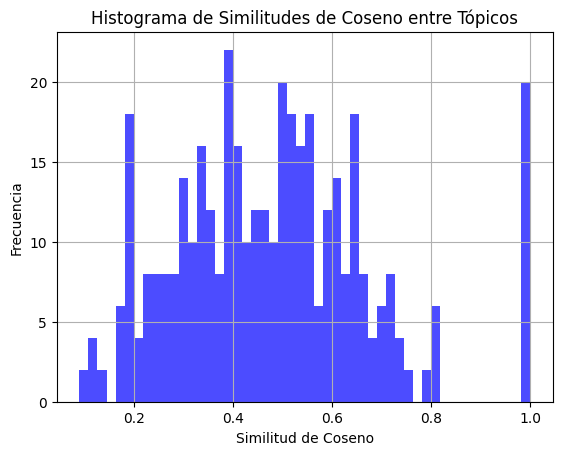

Media de Similitudes: 0.47934216260910034
Desviación Estándar de Similitudes: 0.19873373210430145
Umbral de Similitud: 0.7774427607655525


In [ ]:
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

# Fusionar los modelos
merged_model = BERTopic.merge_models([topic_model_1, topic_model_2])

# Obtener embeddings de los tópicos
merged_embeddings = merged_model.topic_embeddings_

# Calcular la similitud de coseno entre los tópicos del modelo fusionado
similarity_matrix = cosine_similarity(merged_embeddings)

# Convertir la matriz de similitudes en una lista
similarities = similarity_matrix.flatten()

# Crear un histograma de las similitudes
plt.hist(similarities, bins=50, color='blue', alpha=0.7)
plt.title('Histograma de Similitudes de Coseno entre Tópicos')
plt.xlabel('Similitud de Coseno')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Calcular la media y la desviación estándar de las similitudes
mean_similarity = similarities.mean()
std_similarity = similarities.std()

print(f"Media de Similitudes: {mean_similarity}")
print(f"Desviación Estándar de Similitudes: {std_similarity}")

# Elegir un umbral basado en la media más 1.5 veces la desviación estándar
threshold = mean_similarity + 1.5 * std_similarity
print(f"Umbral de Similitud: {threshold}")


Verificación de Tópicos Nuevos y Existentes
Usamos el umbral para identificar los tópicos nuevos y existentes:

In [ ]:
# Función para identificar nuevos y existentes
def identify_new_and_existing_topics(topic_model_1, topic_model_2, merged_model, similarity_matrix, threshold):
    original_topics_1 = set(topic_model_1.get_topic_info()['Topic'])
    original_topics_2 = set(topic_model_2.get_topic_info()['Topic'])
    merged_topics = set(merged_model.get_topic_info()['Topic'])

    new_topics = []
    existing_topics = []

    for i, topic in enumerate(merged_topics):
        similarity_1 = cosine_similarity([merged_model.topic_embeddings_[topic]], topic_model_1.topic_embeddings_).max()
        similarity_2 = cosine_similarity([merged_model.topic_embeddings_[topic]], topic_model_2.topic_embeddings_).max()
        if similarity_1 >= threshold or similarity_2 >= threshold:
            existing_topics.append(topic)
        else:
            new_topics.append(topic)

    return new_topics, existing_topics

# Identificar nuevos y existentes
new_topics, existing_topics = identify_new_and_existing_topics(topic_model_1, topic_model_2, merged_model, similarity_matrix, threshold)

# Mostrar resultados
print(f"Nuevos tópicos: {new_topics}")
print(f"Tópicos existentes: {existing_topics}")


Nuevos tópicos: []
Tópicos existentes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, -1]


Almacenamiento en OpenSearch

Almacenamos los embeddings de los tópicos en OpenSearch y verificamos el almacenamiento:

In [ ]:
from opensearchpy import OpenSearch, helpers
from datetime import datetime

# Configurar conexión a OpenSearch
os_client = OpenSearch(
    hosts=[{'host': 'localhost', 'port': 9200}],
    http_auth=('admin', 'PassWord#1234!'),  # Asegúrate de que estas credenciales sean correctas
    use_ssl=False,  # Cambia esto a True si estás utilizando SSL/TLS
    verify_certs=False  # Cambia esto a True si estás verificando certificados SSL/TLS
)

# Probar la conexión obteniendo el estado del clúster
try:
    health = os_client.cluster.health()
    print("Cluster Health:", health)
except Exception as e:
    print("Error al conectar con OpenSearch:", e)


Error al conectar con OpenSearch: ConnectionError(('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))) caused by: ProtocolError(('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')))


In [ ]:
from opensearchpy import OpenSearch, helpers
from datetime import datetime

# Configurar conexión a OpenSearch
os_client = OpenSearch(
    hosts=[{'host': 'localhost', 'port': 9200}],
    http_auth=('admin', 'PassWord#1234!')
)

# Definir el esquema de los tópicos
index_name = 'topics'
if not os_client.indices.exists(index=index_name):
    os_client.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "vector": {"type": "knn_vector", "dimension": merged_embeddings.shape[1]},
                "keywords": {"type": "text"},
                "fecha": {"type": "date"},
                "umbral": {"type": "float"},
                "nombre": {"type": "text"}
            }
        }
    })

# Función para generar documentos de tópicos
def generate_topic_docs(topic_embeddings, topic_model, date, threshold):
    for topic_id, topic_embed in enumerate(topic_embeddings):
        yield {
            "_index": index_name,
            "_id": f"{date}_{topic_id}",
            "_source": {
                "vector": topic_embed.tolist(),
                "keywords": topic_model.get_topic(topic_id),
                "fecha": date,
                "umbral": threshold,
                "nombre": f"Tópico {topic_id}"
            }
        }

# Almacenar los tópicos en OpenSearch
helpers.bulk(os_client, generate_topic_docs(merged_embeddings, merged_model, '2024-07-01_to_2024-07-12', threshold))

# Verificar almacenamiento
response = os_client.search(index=index_name, body={"query": {"match_all": {}}})
print(response['hits']['hits'])


ConnectionError: ConnectionError(('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))) caused by: ProtocolError(('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))

Inferencia
Finalmente, clasificamos un nuevo texto en los tópicos existentes y extraemos las entidades, keywords y realizamos análisis de sentimiento utilizando pipelines de Hugging Face:

In [ ]:
from transformers import pipeline

# Configuración de pipelines para NER y análisis de sentimiento
ner_pipeline = pipeline('ner', model='dbmdz/bert-large-cased-finetuned-conll03-english')
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

def classify_text(title, text, topic_model):
    combined_text = title + " " + text
    new_embed = topic_model.embedding_model.embed([combined_text])
    query = {
        "size": 1,
        "query": {
            "knn": {
                "vector": {
                    "vector": new_embed[0].tolist(),
                    "k": 1
                }
            }
        }
    }
    response = os_client.search(index=index_name, body=query)
    if response['hits']['hits']:
        topic_id = response['hits']['hits'][0]['_id']
        keywords = response['hits']['hits'][0]['_source']['keywords']
        entities = extract_entities(combined_text)
        sentiment = analyze_sentiment(combined_text)
        return topic_id, keywords, entities, sentiment
    return None, None, None, None

# Función para extracción de entidades
def extract_entities(text):
    entities = ner_pipeline(text)
    return [entity['word'] for entity in entities]

# Función para análisis de sentimiento
def analyze_sentiment(text):
    sentiment = sentiment_pipeline(text)
    return sentiment[0]


# Ejemplo de clasificación
new_title = "Argentina Campeon"
new_text = "Termino la copa America y Argentina salio campeon"
topic_id, keywords, entities, sentiment = classify_text(new_title, new_text, new_topic_model)
print(f"Tópico: {topic_id}, Keywords: {keywords}, Entidades: {entities}, Sentimiento: {sentiment}")


**Definición de Funciones para el Procesamiento de todos los datasets:** 